In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import display


In [76]:
# Load the dataset
data = pd.read_csv('2022_batting_stats.csv')

#print columns for structure
print(data.columns)

# Filter players with at least 200 at bats to remove small sample sizes
data = data[data["AB"] >= 200]
data.dtypes
data.head()

Index(['Rk', 'Name', 'Age', 'Tm', 'Lg', 'G', 'PA', 'AB', 'R', 'H', '2B', '3B',
       'HR', 'RBI', 'SB', 'CS', 'BB', 'SO', 'BA', 'OBP', 'SLG', 'OPS', 'OPS+',
       'TB', 'GDP', 'HBP', 'SH', 'SF', 'IBB'],
      dtype='object')


,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,...,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,1,CJ Abrams*,21,TOT,NL,90,302,284,33,70,...,0.280,0.324,0.604,76,92,5,9,2,2,0
5,6,José Abreu,35,CHW,AL,157,679,601,85,183,...,0.378,0.446,0.824,134,268,19,12,0,4,2
6,7,Ronald Acuna Jr.,24,ATL,NL,119,533,467,71,124,...,0.351,0.413,0.764,112,193,8,10,0,3,4
7,8,Willy Adames,26,MIL,NL,139,617,563,83,134,...,0.298,0.458,0.756,111,258,11,1,0,4,3
9,10,Jo Adell,23,LAA,AL,88,285,268,22,60,...,0.264,0.373,0.637,78,100,6,4,0,1,0


In [77]:
data["wOBA"] = (
    (0.69 * data["BB"]) + # Walks
    (0.72 * data["HBP"]) + # Hit by Pitch
    (0.89 * (data["H"] - data["2B"]- data["3B"] - data["HR"])) + # Singles
    (1.27 * data["2B"]) + # Double
    (1.62 * data["3B"]) + # Triple
    (2.10 * data["HR"]) # Homerun
) / (data["PA"] - data["IBB"])
# Calculating weighted on-base average

data["BABIP"] = (data["H"] - data["HR"])/(data["AB"] - data["SO"] - data["HR"] + data["SF"])
#Calculate Batting Average for Balls In Play

data["K%"] = data["SO"] / data["AB"]
#Strikeout %

data["BB%"] = data["BB"] / data["AB"]
#Base on Balls %

data["XBH"] = data["2B"] + data["3B"] + data["HR"]
#Extra base hits 

#Display new metrics
data[["Name", "OPS", "OBP", "SLG", "wOBA", "BABIP", "K%", "BB%"]].head()

,Name,OPS,OBP,SLG,wOBA,BABIP,K%,BB%
0,CJ Abrams*,0.604,0.280,0.324,0.267119,0.290598,0.176056,0.017606
5,José Abreu,0.824,0.378,0.446,0.365790,0.350000,0.183028,0.103161
6,Ronald Acuna Jr.,0.764,0.351,0.413,0.342911,0.331307,0.269807,0.113490
7,Willy Adames,0.756,0.298,0.458,0.330749,0.278378,0.294849,0.087034
9,Jo Adell,0.637,0.264,0.373,0.279193,0.337662,0.399254,0.041045


In [78]:
# Rank players based on key performance metrics (higher is better for all)
data["OPS_rank"] = data["OPS"].rank(ascending=False) #OPS
data["OPS+_rank"] = data["OPS+"].rank(ascending=False)  # Adjusted OPS+
data["RBI_rank"] = data["RBI"].rank(ascending=False) #RBI's
data["BA_rank"] = data["BA"].rank(ascending=False) #Batting average
data["OBP_rank"] = data["OBP"].rank(ascending=False) #On base percentage
data["SLG_rank"] = data["SLG"].rank(ascending=False) #Slugging
data["HR_rank"] = data["HR"].rank(ascending=False) # Homerun rank
data["TB_rank"] = data["TB"].rank(ascending=False)  # Total Bases
data["H_rank"] = data["H"].rank(ascending=False)  # Hits
data["PA_rank"] = data["PA"].rank(ascending=False)  # Plate Appearances
data["AB_rank"] = data["AB"].rank(ascending=False)  # At-Bats
data["R_rank"] = data["R"].rank(ascending=False)  # Runs
data["SB_rank"] = data["SB"].rank(ascending=False)  # Stolen Bases
data["CS_rank"] = data["CS"].rank(ascending=True)  # Caught Stealing (lower is better)
data["BB_rank"] = data["BB"].rank(ascending=False)  # Walks
data["SO_rank"] = data["SO"].rank(ascending=True)  # Strikeouts (lower is better)
data["GDP_rank"] = data["GDP"].rank(ascending=True)  # Grounded Into Double Plays (lower is better)
data["HBP_rank"] = data["HBP"].rank(ascending=False)  # Hit By Pitch
data["SH_rank"] = data["SH"].rank(ascending=False)  # Sacrifice Hits
data["SF_rank"] = data["SF"].rank(ascending=False)  # Sacrifice Flies
data["IBB_rank"] = data["IBB"].rank(ascending=False)  # Intentional Walks
data["XBH_rank"] = data["XBH"].rank(ascending=False) #Extra Base hits

# Composite ranking: Average of all ranks to get an overall offensive score
data["Rank_AVG"] = (
    data["OPS_rank"] + data["OPS+_rank"] + data["BA_rank"] + data["OBP_rank"] +
    data["SLG_rank"] + data["HR_rank"] + data["RBI_rank"] + data["H_rank"] +
    data["TB_rank"] + data["SB_rank"] + data["BB_rank"] - data["SO_rank"]
) / 11  # Adjust denominator based on metrics used

# Find undervalues players, high ops low RBIs
hidden_gems = data[
    (data["OPS_rank"] <= data["OPS_rank"].quantile(0.3)) & # Top 30% in ops
    (data["RBI_rank"] >= data["RBI_rank"].quantile(0.5)) & # Bottom 50% in RBI
    (data["BB%"] >= data["BB%"].quantile(0.6)) & # Top 40% in walk rate
    (data["K%"] <= data["K%"].quantile(0.6)) # Bottom 40% in strikeouts
]


In [79]:
#identify players exceeding expected OPS
display(hidden_gems[["Name", "Tm", "G", "PA", "H","XBH", "HR", "BA", "OPS", "RBI", "wOBA", "SLG", "K%", "BB%", "Rank_AVG"]].head(20))

,Name,Tm,G,PA,H,XBH,HR,BA,OPS,RBI,wOBA,SLG,K%,BB%,Rank_AVG
96,Andrew Benintendi*,KCR,93,390,111,19,3,0.320,0.785,39,0.350846,0.398,0.149856,0.112392,138.545455
123,Michael Brantley*,HOU,64,277,70,20,5,0.288,0.785,26,0.350945,0.416,0.123457,0.127572,180.863636
250,Brendan Donovan*,STL,126,468,110,27,5,0.281,0.773,45,0.351478,0.379,0.179028,0.153453,130.409091
307,Jake Fraley*,CIN,68,247,56,21,12,0.259,0.812,28,0.357236,0.468,0.250000,0.120370,166.590909
445,Danny Jansen,TOR,72,248,56,25,15,0.260,0.855,44,0.369231,0.516,0.204651,0.116279,154.590909
644,Lars Nootbaar*,STL,108,347,66,33,14,0.228,0.788,40,0.346416,0.448,0.244828,0.175862,142.681818
676,Vinnie Pasquantino*,KCR,72,298,76,20,10,0.295,0.832,26,0.369865,0.450,0.131783,0.135659,151.272727
797,Adley Rutschman#,BAL,113,470,101,49,13,0.254,0.806,42,0.356128,0.445,0.216080,0.163317,95.409091


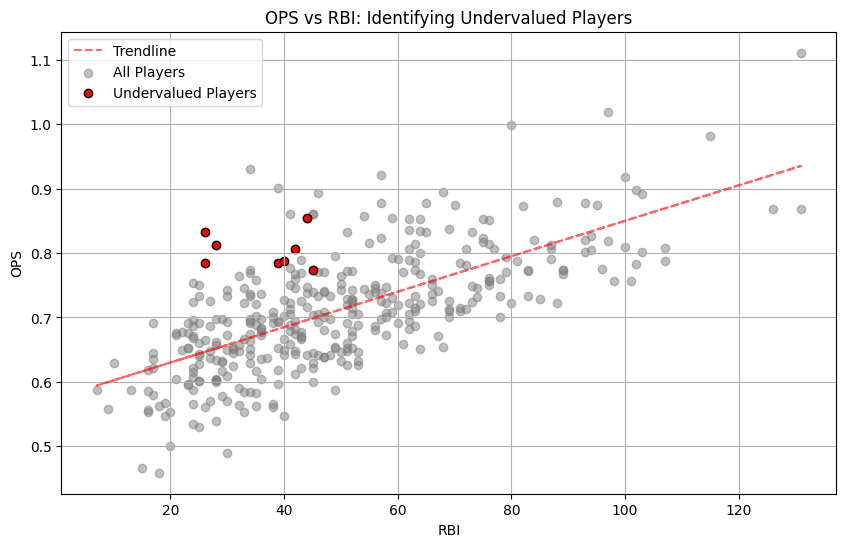

In [80]:
#Visualization OPS vs RBI
plt.figure(figsize=(10,6))

# Trendline
z = np.polyfit(data["RBI"], data["OPS"], 1)
p = np.poly1d(z)
plt.plot(data["RBI"], p(data["RBI"]), "r--", alpha=0.6, label="Trendline")

#plot players
plt.scatter(data["RBI"], data["OPS"], alpha=0.5, color="gray", label="All Players")

#plot undervalued
plt.scatter(hidden_gems["RBI"], hidden_gems["OPS"], color="red", edgecolors="black", label="Undervalued Players")

plt.xlabel("RBI")
plt.ylabel("OPS")
plt.title("OPS vs RBI: Identifying Undervalued Players")
plt.legend()
plt.grid(True)
plt.show()

In [81]:
#Identifying undervalued players by OPS and RBI
data["Hits per OPS"] = data["H"] / data["OPS"]
data.sort_values(by="Hits per OPS", ascending = True, inplace = True) # Lower hits per ops suggests player is underrated

In [82]:
#Regression model to predict OPS
X = data[["H", "BB", "HR", "SLG", "OBP"]]
y = data["OPS"]

X = sm.add_constant(X)

model = sm.OLS(data["OPS"], X).fit()
data["OPS Predicted"] = model.predict(X)
data["Residual"] = data["OPS"] - data["OPS Predicted"]

# Players with a high positive residual = undervalued players'
data.sort_values(by="Residual", ascending=False).head(10)

,Rk,Name,Age,Tm,Lg,G,PA,AB,R,H,...,GDP_rank,HBP_rank,SH_rank,SF_rank,IBB_rank,XBH_rank,Rank_AVG,Hits per OPS,OPS Predicted,Residual
530,531,Nick Madrigal,25,CHC,NL,59,228,209,19,52,...,129.0,232.0,47.0,353.5,276.5,371.0,309.181818,88.435374,0.586889,0.001111
465,466,Isiah Kiner-Falefa,27,NYY,AL,142,531,483,66,126,...,320.0,143.0,25.0,63.0,73.0,259.5,183.727273,196.261682,0.640926,0.001074
568,569,Reese McGuire*,27,TOT,AL,89,274,249,25,67,...,129.0,232.0,8.0,170.0,276.5,314.5,264.181818,98.966027,0.675937,0.001063
966,967,Joey Wendle*,32,MIA,NL,101,371,347,27,90,...,165.5,143.0,84.0,170.0,276.5,217.0,235.772727,136.778116,0.656948,0.001052
310,311,Wander Franco#,21,TBR,AL,83,344,314,46,87,...,91.5,361.5,240.0,111.5,137.5,205.5,167.681818,116.621984,0.744953,0.001047
367,368,Robbie Grossman#,32,TOT,MLB,129,477,411,40,86,...,45.5,108.0,240.0,111.5,276.5,230.5,204.363636,138.263666,0.620957,0.001043
950,951,LaMonte Wade Jr.*,28,SFG,NL,77,251,217,29,45,...,4.5,143.0,47.0,302.0,276.5,336.0,282.454545,67.669173,0.663971,0.001029
213,214,Nelson Cruz,41,WSN,NL,124,507,448,50,105,...,349.0,181.5,240.0,170.0,137.5,239.5,168.090909,161.290323,0.649972,0.001028
592,593,Whit Merrifield,33,KCR,AL,95,420,383,51,92,...,198.5,361.5,240.0,17.0,276.5,196.0,221.181818,143.079316,0.641979,0.001021
53,54,Orlando Arcia,27,ATL,NL,67,234,209,25,51,...,165.5,285.5,240.0,235.5,276.5,314.5,234.181818,69.577080,0.731982,0.001018


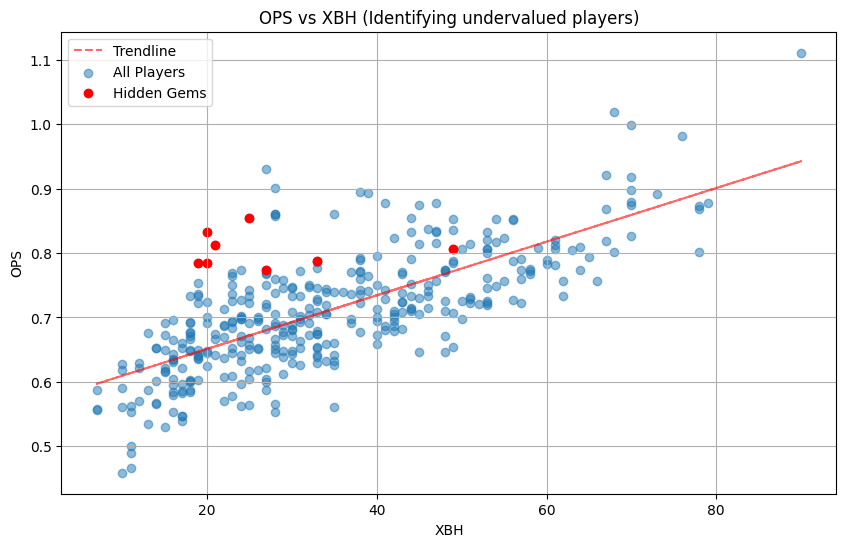

In [83]:
# VISUALIZATION: OPS vs XBH with trendline
plt.figure(figsize=(10,6))
# Trendline
z = np.polyfit(data["XBH"], data["OPS"], 1)
p = np.poly1d(z)
plt.plot(data["XBH"], p(data["XBH"]), "r--", alpha=0.6, label="Trendline")

plt.scatter(data["XBH"], data["OPS"], alpha=0.5, label="All Players")
plt.scatter(hidden_gems["XBH"], hidden_gems["OPS"], color="red", label="Hidden Gems")
plt.xlabel("XBH")
plt.ylabel("OPS")
plt.title("OPS vs XBH (Identifying undervalued players)")
plt.legend()
plt.grid(True)
plt.show()

In [84]:
hidden_gemsxbh = data[
    (data["OPS_rank"] <= data["OPS_rank"].quantile(0.3)) & # Top 30% in XBH
    (data["XBH_rank"] >= data["XBH_rank"].quantile(0.5)) # bottom 50% in XBH
]
# Offensive players that have low XBH's, but a high OPS. These players have a higher OBP and likely hit singles
display(hidden_gemsxbh[["Name", "BA", "H", "RBI", "OPS", "XBH", "OBP", "SLG", "BB%", "K%", "OPS Predicted", "Residual"]].head(20))

,Name,BA,H,RBI,OPS,XBH,OBP,SLG,BB%,K%,OPS Predicted,Residual
898,Trayce Thompson,0.268,55,39,0.901,28,0.364,0.537,0.146341,0.419512,0.900995,0.000005
612,Dylan Moore,0.224,46,24,0.753,19,0.368,0.385,0.165854,0.365854,0.752892,0.000108
190,Jazz Chisholm Jr.*,0.254,54,45,0.860,28,0.325,0.535,0.098592,0.309859,0.860046,-0.000046
896,Trayce Thompson,0.256,56,41,0.860,28,0.353,0.507,0.146119,0.424658,0.859998,0.000002
445,Danny Jansen,0.260,56,44,0.855,25,0.339,0.516,0.116279,0.204651,0.855026,-0.000026
307,Jake Fraley*,0.259,56,28,0.812,21,0.344,0.468,0.120370,0.250000,0.811984,0.000016
424,Keston Hiura,0.226,53,32,0.765,23,0.316,0.449,0.098291,0.474359,0.765021,-0.000021
942,Daniel Vogelbach*,0.228,54,34,0.769,23,0.338,0.430,0.168776,0.282700,0.767985,0.001015
584,Joey Meneses,0.324,72,34,0.930,27,0.367,0.563,0.067568,0.234234,0.929991,0.000009
507,Evan Longoria,0.244,65,42,0.767,27,0.315,0.451,0.101504,0.312030,0.766026,0.000974


In [85]:
display(hidden_gems[["Name", "Tm", "G", "Age", "H", "XBH", "BA", "OPS", "wOBA", "RBI", "BB%", "K%"]])
#Display top undervalued players

,Name,Tm,G,Age,H,XBH,BA,OPS,wOBA,RBI,BB%,K%
96,Andrew Benintendi*,KCR,93,27,111,19,0.320,0.785,0.350846,39,0.112392,0.149856
123,Michael Brantley*,HOU,64,35,70,20,0.288,0.785,0.350945,26,0.127572,0.123457
250,Brendan Donovan*,STL,126,25,110,27,0.281,0.773,0.351478,45,0.153453,0.179028
307,Jake Fraley*,CIN,68,27,56,21,0.259,0.812,0.357236,28,0.120370,0.250000
445,Danny Jansen,TOR,72,27,56,25,0.260,0.855,0.369231,44,0.116279,0.204651
644,Lars Nootbaar*,STL,108,24,66,33,0.228,0.788,0.346416,40,0.175862,0.244828
676,Vinnie Pasquantino*,KCR,72,24,76,20,0.295,0.832,0.369865,26,0.135659,0.131783
797,Adley Rutschman#,BAL,113,24,101,49,0.254,0.806,0.356128,42,0.163317,0.216080


In [86]:
league_avg_ops = data["OPS"].mean()
league_avg_rbi = data["RBI"].mean()
#Calculating league average for comparison

#Comparison of undervalued players to the league average
top_undervalued = hidden_gems.nlargest(10, "OPS")
for index, player in top_undervalued.iterrows():
    print(f"{player['Name']}: OPS = {player['OPS']:.3f} (League Avg: {league_avg_ops:.3f}), RBI = {player['RBI']} (League Avg: {league_avg_rbi:.0f})")

Danny Jansen: OPS = 0.855 (League Avg: 0.711), RBI = 44 (League Avg: 49)
Vinnie Pasquantino*: OPS = 0.832 (League Avg: 0.711), RBI = 26 (League Avg: 49)
Jake Fraley*: OPS = 0.812 (League Avg: 0.711), RBI = 28 (League Avg: 49)
Adley Rutschman#: OPS = 0.806 (League Avg: 0.711), RBI = 42 (League Avg: 49)
Lars Nootbaar*: OPS = 0.788 (League Avg: 0.711), RBI = 40 (League Avg: 49)
Andrew Benintendi*: OPS = 0.785 (League Avg: 0.711), RBI = 39 (League Avg: 49)
Michael Brantley*: OPS = 0.785 (League Avg: 0.711), RBI = 26 (League Avg: 49)
Brendan Donovan*: OPS = 0.773 (League Avg: 0.711), RBI = 45 (League Avg: 49)


In [87]:
top_OPS_players = data.nlargest(10, "OPS")
top_wOBA_players = data.nlargest(10, "wOBA")
top_HR_players = data.nlargest(10, "HR")
top_BA_players = data.nlargest(10, "BA")
top_RBI_players = data.nlargest(10, "RBI")
#top 10 of *topic* added for comparison of undervalued

print("Top 10 Undervalued players: ")
display(top_undervalued[["Name", "Tm", "G", "PA", "BA", "H", "XBH", "HR", "OPS", "RBI", "BB%", "K%"]])

print("Top 10 RBI players: ")
display(top_RBI_players[["Name", "Tm", "G", "PA", "BA", "H", "XBH", "HR", "OPS", "RBI", "BB%", "K%"]])

print("Top 10 OPS players: ")
display(top_OPS_players[["Name", "Tm", "G", "PA", "BA", "H", "XBH", "HR", "OPS", "RBI", "BB%", "K%"]])

print("Top 10 wOBA players: ")
display(top_wOBA_players[["Name", "Tm", "G", "PA", "BA", "H", "XBH", "HR", "OPS", "RBI", "BB%", "K%"]])

print("Top 10 HR players: ")
display(top_HR_players[["Name", "Tm", "G", "PA", "BA", "H", "XBH", "HR", "OPS", "RBI", "BB%", "K%"]])

print("Top 10 BA players: ")
display(top_BA_players[["Name", "Tm", "G", "PA", "BA", "H", "XBH", "HR", "OPS", "RBI", "BB%", "K%"]])

Top 10 Undervalued players: 


,Name,Tm,G,PA,BA,H,XBH,HR,OPS,RBI,BB%,K%
445,Danny Jansen,TOR,72,248,0.260,56,25,15,0.855,44,0.116279,0.204651
676,Vinnie Pasquantino*,KCR,72,298,0.295,76,20,10,0.832,26,0.135659,0.131783
307,Jake Fraley*,CIN,68,247,0.259,56,21,12,0.812,28,0.120370,0.250000
797,Adley Rutschman#,BAL,113,470,0.254,101,49,13,0.806,42,0.163317,0.216080
644,Lars Nootbaar*,STL,108,347,0.228,66,33,14,0.788,40,0.175862,0.244828
96,Andrew Benintendi*,KCR,93,390,0.320,111,19,3,0.785,39,0.112392,0.149856
123,Michael Brantley*,HOU,64,277,0.288,70,20,5,0.785,26,0.127572,0.123457
250,Brendan Donovan*,STL,126,468,0.281,110,27,5,0.773,45,0.153453,0.179028


Top 10 RBI players: 


,Name,Tm,G,PA,BA,H,XBH,HR,OPS,RBI,BB%,K%
452,Aaron Judge,NYY,157,696,0.311,177,90,62,1.111,131,0.194737,0.307018
32,Pete Alonso,NYM,160,685,0.271,162,67,40,0.869,131,0.112228,0.214405
732,José Ramírez#,CLE,157,685,0.280,168,78,29,0.869,126,0.114809,0.136439
343,Paul Goldschmidt,STL,151,651,0.317,178,76,35,0.981,115,0.140820,0.251337
913,Kyle Tucker*,HOU,150,609,0.257,140,59,30,0.808,107,0.108456,0.174632
504,Francisco Lindor#,NYM,161,706,0.270,170,56,26,0.788,107,0.093651,0.211111
54,Nolan Arenado,STL,148,620,0.293,163,73,30,0.891,103,0.093357,0.129264
657,Matt Olson*,ATL,162,699,0.240,148,78,34,0.802,103,0.121753,0.275974
210,C.J. Cron,COL,150,632,0.257,148,60,29,0.783,102,0.074783,0.285217
525,Manny Machado,SDP,150,644,0.298,172,70,32,0.898,102,0.108997,0.230104


Top 10 OPS players: 


,Name,Tm,G,PA,BA,H,XBH,HR,OPS,RBI,BB%,K%
452,Aaron Judge,NYY,157,696,0.311,177,90,62,1.111,131,0.194737,0.307018
37,Yordan Alvarez*,HOU,135,561,0.306,144,68,37,1.019,97,0.165957,0.225532
910,Mike Trout,LAA,119,499,0.283,124,70,40,0.999,80,0.123288,0.317352
343,Paul Goldschmidt,STL,151,651,0.317,178,76,35,0.981,115,0.140820,0.251337
584,Joey Meneses,WSN,56,240,0.324,72,27,13,0.930,34,0.067568,0.234234
33,Jose Altuve,HOU,141,604,0.300,158,67,28,0.921,57,0.125237,0.165085
313,Freddie Freeman*,LAD,159,708,0.325,199,70,21,0.918,100,0.137255,0.166667
898,Trayce Thompson,LAD,74,239,0.268,55,28,13,0.901,39,0.146341,0.419512
525,Manny Machado,SDP,150,644,0.298,172,70,32,0.898,102,0.108997,0.230104
724,Albert Pujols,STL,109,351,0.270,83,38,24,0.895,68,0.091205,0.179153


Top 10 wOBA players: 


,Name,Tm,G,PA,BA,H,XBH,HR,OPS,RBI,BB%,K%
452,Aaron Judge,NYY,157,696,0.311,177,90,62,1.111,131,0.194737,0.307018
37,Yordan Alvarez*,HOU,135,561,0.306,144,68,37,1.019,97,0.165957,0.225532
910,Mike Trout,LAA,119,499,0.283,124,70,40,0.999,80,0.123288,0.317352
343,Paul Goldschmidt,STL,151,651,0.317,178,76,35,0.981,115,0.140820,0.251337
313,Freddie Freeman*,LAD,159,708,0.325,199,70,21,0.918,100,0.137255,0.166667
584,Joey Meneses,WSN,56,240,0.324,72,27,13,0.930,34,0.067568,0.234234
33,Jose Altuve,HOU,141,604,0.300,158,67,28,0.921,57,0.125237,0.165085
851,Juan Soto*,WSN,101,436,0.246,84,39,21,0.894,46,0.266082,0.181287
525,Manny Machado,SDP,150,644,0.298,172,70,32,0.898,102,0.108997,0.230104
898,Trayce Thompson,LAD,74,239,0.268,55,28,13,0.901,39,0.146341,0.419512


Top 10 HR players: 


,Name,Tm,G,PA,BA,H,XBH,HR,OPS,RBI,BB%,K%
452,Aaron Judge,NYY,157,696,0.311,177,90,62,1.111,131,0.194737,0.307018
813,Kyle Schwarber*,PHI,155,669,0.218,126,70,46,0.827,94,0.149047,0.346620
910,Mike Trout,LAA,119,499,0.283,124,70,40,0.999,80,0.123288,0.317352
32,Pete Alonso,NYM,160,685,0.271,162,67,40,0.869,131,0.112228,0.214405
755,Austin Riley,ATL,159,693,0.273,168,79,38,0.878,93,0.092683,0.273171
37,Yordan Alvarez*,HOU,135,561,0.306,144,68,37,1.019,97,0.165957,0.225532
952,Christian Walker,ARI,160,667,0.242,141,63,36,0.804,94,0.118353,0.224700
888,Rowdy Tellez*,MIL,153,599,0.219,116,58,35,0.767,89,0.117202,0.228733
104,Mookie Betts,LAD,142,639,0.269,154,78,35,0.873,82,0.096154,0.181818
343,Paul Goldschmidt,STL,151,651,0.317,178,76,35,0.981,115,0.140820,0.251337


Top 10 BA players: 


,Name,Tm,G,PA,BA,H,XBH,HR,OPS,RBI,BB%,K%
577,Jeff McNeil*,NYM,148,589,0.326,174,49,9,0.836,62,0.075047,0.114447
313,Freddie Freeman*,LAD,159,708,0.325,199,70,21,0.918,100,0.137255,0.166667
584,Joey Meneses,WSN,56,240,0.324,72,27,13,0.930,34,0.067568,0.234234
96,Andrew Benintendi*,KCR,93,390,0.320,111,19,3,0.785,39,0.112392,0.149856
343,Paul Goldschmidt,STL,151,651,0.317,178,76,35,0.981,115,0.140820,0.251337
57,Luis Arraez*,MIN,144,603,0.316,173,40,8,0.795,49,0.091408,0.078611
452,Aaron Judge,NYY,157,696,0.311,177,90,62,1.111,131,0.194737,0.307018
113,Xander Bogaerts,BOS,150,631,0.307,171,53,15,0.833,73,0.102334,0.211849
37,Yordan Alvarez*,HOU,135,561,0.306,144,68,37,1.019,97,0.165957,0.225532
95,Andrew Benintendi*,TOT,126,521,0.304,140,31,5,0.772,51,0.112798,0.167028


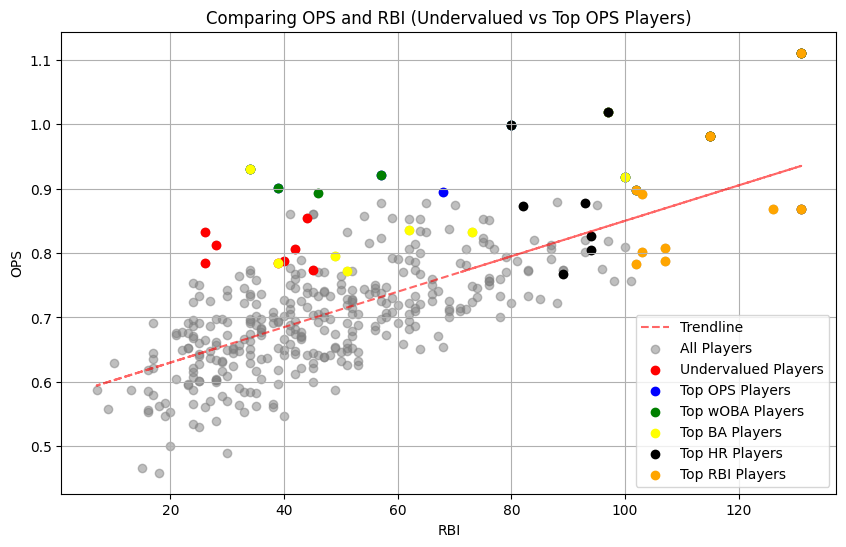

In [88]:
#Visualizing OPS and RBI highlighting league leaders in RBI, OPS, HRs, BA, wOBA
plt.figure(figsize=(10,6))
# Trendline
z = np.polyfit(data["RBI"], data["OPS"], 1)
p = np.poly1d(z)
plt.plot(data["RBI"], p(data["RBI"]), "r--", alpha=0.6, label="Trendline")

#Scatterplot for all players
plt.scatter(data["RBI"], data["OPS"], alpha=0.5, label = "All Players", color="gray")

#highlight undervalued
plt.scatter(top_undervalued["RBI"], top_undervalued["OPS"], color="red", label="Undervalued Players")

# top OPS players
plt.scatter(top_OPS_players["RBI"], top_OPS_players["OPS"], color="blue", label="Top OPS Players")

#Top wOBA players
plt.scatter(top_wOBA_players["RBI"], top_wOBA_players["OPS"], color="green", label="Top wOBA Players")

#Top BA Players
plt.scatter(top_BA_players["RBI"], top_BA_players["OPS"], color="yellow", label="Top BA Players")

#Top HR players
plt.scatter(top_HR_players["RBI"], top_HR_players["OPS"], color="black", label="Top HR Players")

#Top RBI players
plt.scatter(top_RBI_players["RBI"], top_RBI_players["OPS"], color="orange", label="Top RBI Players")

plt.xlabel("RBI")
plt.ylabel("OPS")
plt.title("Comparing OPS and RBI (Undervalued vs Top OPS Players)")
plt.legend()
plt.grid(True)
plt.show()